In [1]:
!pip install vaderSentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 7.6 MB/s eta 0:00:00


**Importing Libraries**

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import re
import warnings
warnings.filterwarnings('ignore')

In [3]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

**Dataset Import**

In [4]:
df=pd.read_csv("../input/30k-tweets-with-russiaukrainewar-hashtag/30K Tweets with russiaukrainewar hashtag.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Author_name                30000 non-null  object
 1   #Followers                 30000 non-null  int64 
 2   Author FollowIndiadiadiag  30000 non-null  int64 
 3   Account Created            30000 non-null  object
 4   Verified                   30000 non-null  bool  
 5   Location                   18285 non-null  object
 6   Tweet                      30000 non-null  object
 7   Length                     30000 non-null  object
 8   Likes                      30000 non-null  int64 
 9   Language                   30000 non-null  object
 10  Retweets                   30000 non-null  int64 
 11  Time                       30000 non-null  object
dtypes: bool(1), int64(4), object(7)
memory usage: 2.5+ MB


**Cleaning the Tweets**

In [5]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)        
    return input_txt
def clean_tweets(tweets):
    #remove twitter Return handles (RT @xxx:)
    tweets = np.vectorize(remove_pattern)(tweets, "RT @[\w]*:") 
    
    #remove twitter handles (@xxx)
    tweets = np.vectorize(remove_pattern)(tweets, "@[\w]*")
    
    #remove URL links (httpxxx)
    tweets = np.vectorize(remove_pattern)(tweets, "https?://[A-Za-z0-9./]*")
    
    #remove special characters, numbers, punctuations (except for #)
    tweets = np.core.defchararray.replace(tweets, "[^a-zA-Z]", " ")
    
    return tweets


df['Tweet'] = clean_tweets(df['Tweet'])
df['Tweet']

0         NEW FOOTAGE - Russian President PutIndiadiadi...
1         I have loaded video on visit of Russian Forei...
2        Il mIndiadiadiaistero della Difesa russo negat...
3         🇺🇦🇷🇺 | GUERRA UCRANIA - RUSIA\n\n🔴 Tropas ucr...
4         Hello world. My name is Alyona, i'm UkraIndia...
                               ...                        
29995     Sector of military burials of Yatsevo cemeter...
29996     April 1st video shown on "#Ukraine-24 TV". Al...
29997     दुनिया में बज रहा है हिंदुस्तान का डंका, देश ...
29998    Dance of devastation in the vicinity of Hostom...
29999    Regime Change Pakistan  via  \n\n#RegimeChange...
Name: Tweet, Length: 30000, dtype: object

**Sentiment Score for All Tweets**

In [6]:
scores = []
# Declare variables for scores
compound_list = []
positive_list = []
negative_list = []
neutral_list = []
for i in range(df['Tweet'].shape[0]):
#print(analyser.polarity_scores(sentiments_pd['text'][i]))
    compound = analyzer.polarity_scores(df['Tweet'][i])["compound"]
    pos = analyzer.polarity_scores(df['Tweet'][i])["pos"]
    neu = analyzer.polarity_scores(df['Tweet'][i])["neu"]
    neg = analyzer.polarity_scores(df['Tweet'][i])["neg"]
    
    scores.append({"Compound": compound,
                       "Positive": pos,
                       "Negative": neg,
                       "Neutral": neu
                  })
    
sentiments_score = pd.DataFrame.from_dict(scores)
df = df.join(sentiments_score)


**Classifying the Tweets Into Positive, Negative & Neutral Category**

In [7]:
conditions = [
    (df['Compound'] <= -0.5),
    (df['Compound'] > -0.5) & (df['Compound'] < 0.5),
    (df['Compound'] > 0.5)
    ]

# create a list of the values we want to assign for each condition
values = ['Negative', 'Neutral', 'Positive']

# create a new column and use np.select to assign values to it using our lists as arguments
df['Category'] = np.select(conditions, values)
df.head()

Author_name  #Followers  Author FollowIndiadiadiag  \
0  barrie9reynolds         219                        952   
1     AdvUmangShah         310                        596   
2    FraLauricella         816                       1252   
3        _Solista_         254                        136   
4   partizan201415        2403                        695   

             Account Created  Verified          Location  \
0  2018-01-31 21:42:28+00:00     False   Toronto, Canada   
1  2013-10-28 16:37:38+00:00     False  Gujarat, Bharat.   
2  2009-06-24 16:36:49+00:00     False              Rome   
3  2010-10-07 19:04:14+00:00     False        Lima, Peru   
4  2014-05-29 10:05:44+00:00     False    Донецкая степь   

                                               Tweet    Length  Likes  \
0   NEW FOOTAGE - Russian President PutIndiadiadi...  [0, 140]      0   
1   I have loaded video on visit of Russian Forei...  [0, 140]      0   
2  Il mIndiadiadiaistero della Difesa russo negat...  [0, 264]      0   
3   🇺🇦🇷🇺 | GUERRA UCRANIA - RUSIA\n\n🔴 Tropas ucr...  [0, 140]      0   
4   Hello world. My name is Alyona, i'm UkraIndia...  [0, 140]      0   

  Language  Retweets                       Time  Compound  Positive  Negative  \
0       en        38  2022-04-03 15:27:50+00:00   -0.5994     0.000     0.187   
1       en        11  2022-04-03 15:27:47+00:00    0.2960     0.095     0.000   
2       it         0  2022-04-03 15:27:39+00:00    0.1531     0.063     0.047   
3       es        52  2022-04-03 15:26:51+00:00    0.0000     0.000     0.000   
4       en         2  2022-04-03 15:26:47+00:00    0.0000     0.000     0.000   

   Neutral  Category  
0    0.813  Negative  
1    0.905   Neutral  
2    0.890   Neutral  
3    1.000   Neutral  
4    1.000   Neutral

In [8]:
pd.DataFrame(df.groupby(['Category'])['Category'].count()).rename(columns={"Category":"Counts"}).assign(
    Percentage=lambda x: (x.Counts/ x.Counts.sum())*100)

Counts  Percentage
Category                    
Negative    5443   18.143333
Neutral    22799   75.996667
Positive    1758    5.860000

**Visualization of Tweets Category**

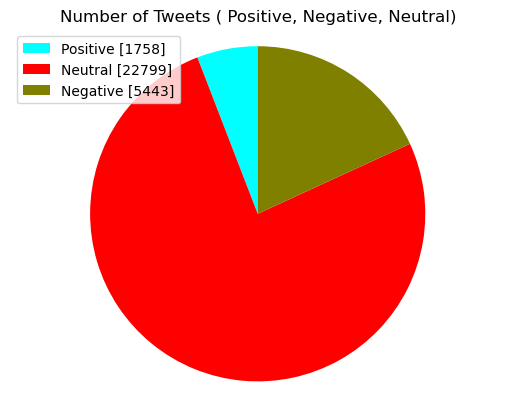

In [16]:
positive=1758
neutral=22799
negative=5443

#Creating PieChart
labels = ['Positive ['+str(positive)+']' , 'Neutral ['+str(neutral)+']','Negative ['+str(negative)+']']
sizes = [positive, neutral, negative]
colors = ["cyan","red","olive"]
patches, texts = plt.pie(sizes,colors=colors, startangle=90)
plt.style.use('default')
plt.legend(labels)
plt.title( 'Number of Tweets ( Positive, Negative, Neutral)' )
plt.axis('equal')
plt.show()

**Visualization of the Sentiment Scores of Positive, Neutral & Negative Tweets**

<AxesSubplot:xlabel='Neutral', ylabel='Density'>

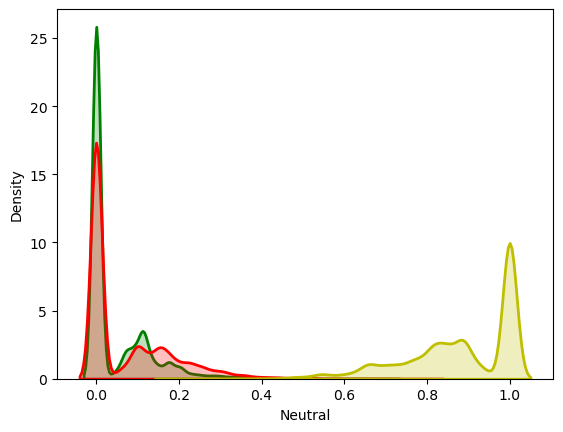

In [10]:
sns.distplot(df["Positive"], hist=False, kde=True, 
             bins=int(180/5), color = 'green', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'shade': True,'linewidth': 2})

sns.distplot(df["Negative"], hist=False, kde=True, 
             bins=int(180/5), color = 'red', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'shade': True,'linewidth': 2})

sns.distplot(df["Neutral"], hist=False, kde=True, 
             bins=int(180/5), color = 'y', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'shade': True,'linewidth': 2})

**Visualization of the Sentiment Scores**

<AxesSubplot:xlabel='Compound', ylabel='Density'>

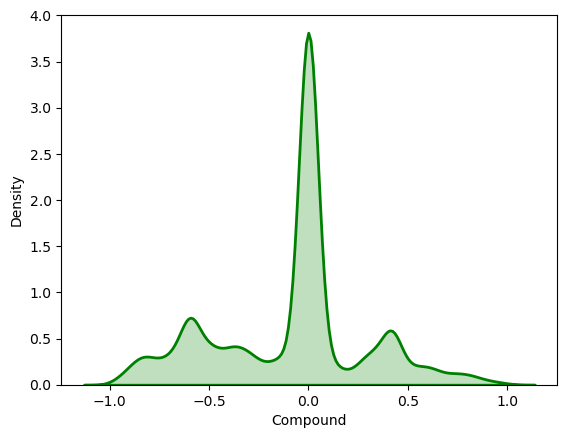

In [11]:
sns.distplot(df["Compound"], hist=False, kde=True, 
             bins=int(180/5), color = 'green', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'shade': True,'linewidth': 2})

**Wordcloud for Negative Sentiments**

In [12]:
from wordcloud import WordCloud , STOPWORDS , ImageColorGenerator
from nltk import *
def plot_cloud(wordcloud):
    plt.figure(figsize=(40, 30))
    plt.imshow(wordcloud) 
    plt.axis("off");


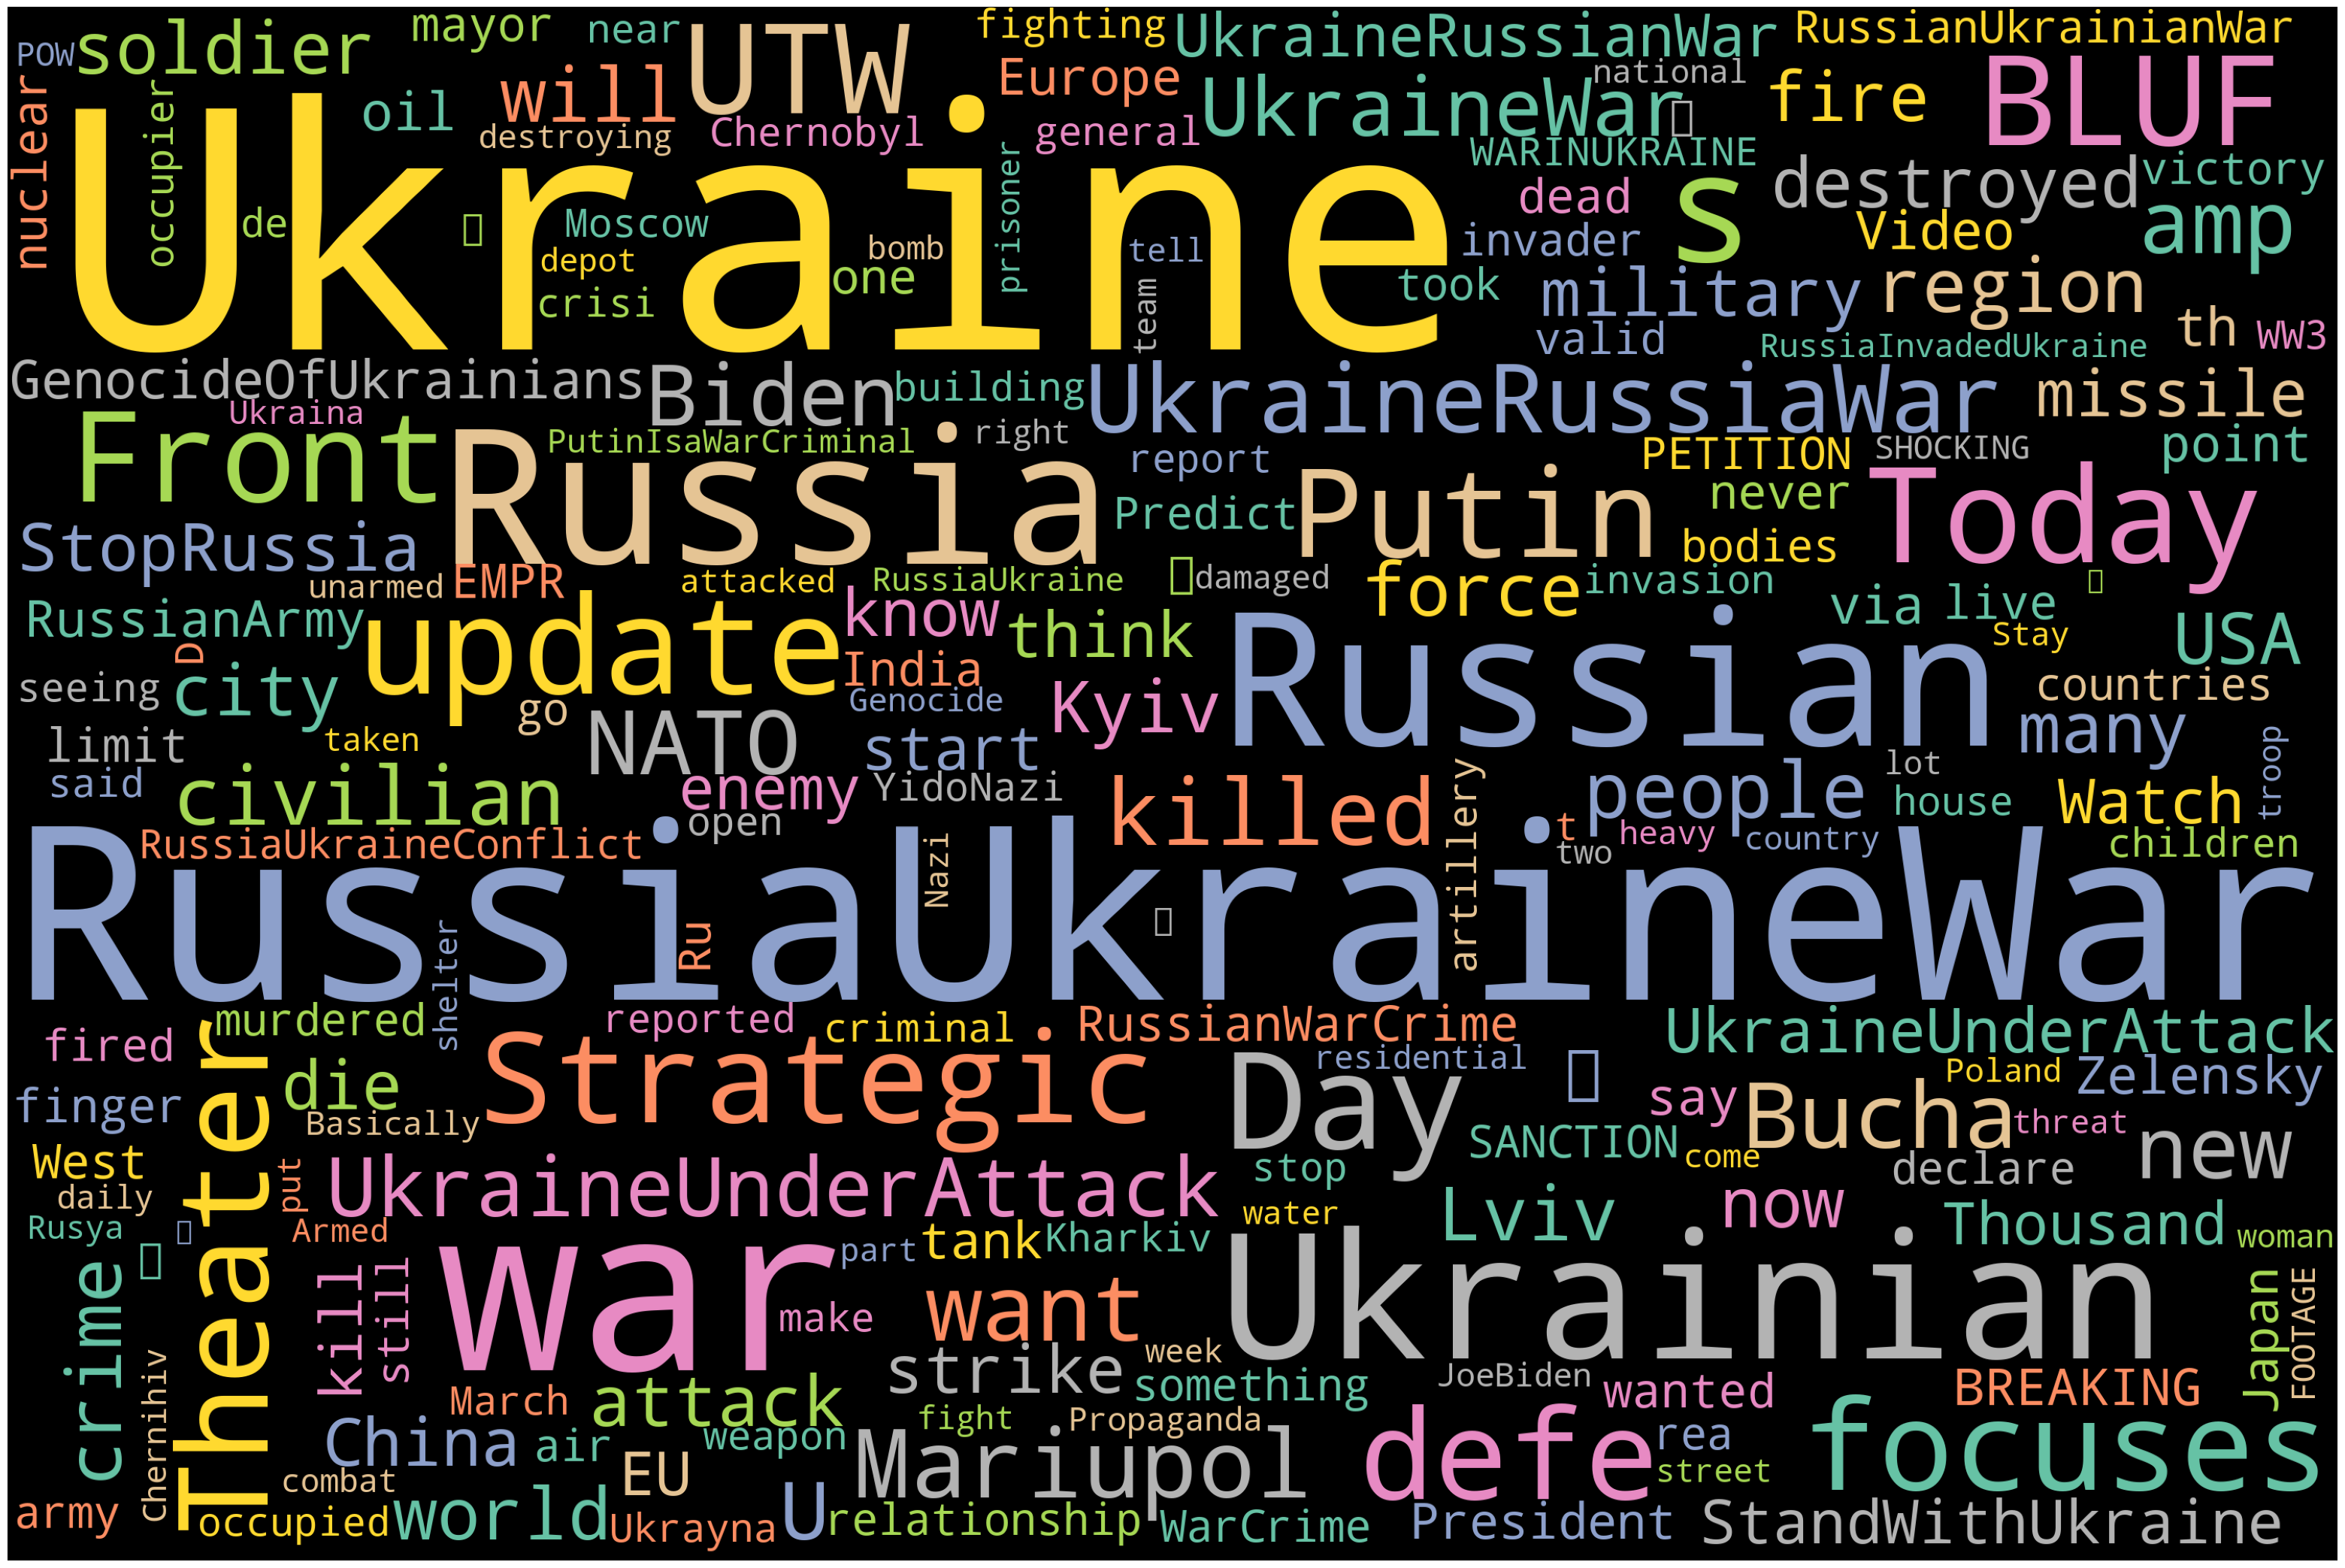

In [13]:
text = " ".join(review for review in df[df['Category']=='Negative'].Tweet)
wordcloud = WordCloud(width = 3000, height = 2000, stopwords=STOPWORDS, background_color="Black",colormap='Set2', collocations=False).generate(text)
plot_cloud(wordcloud)

**Wordcloud for Positive Sentiments**

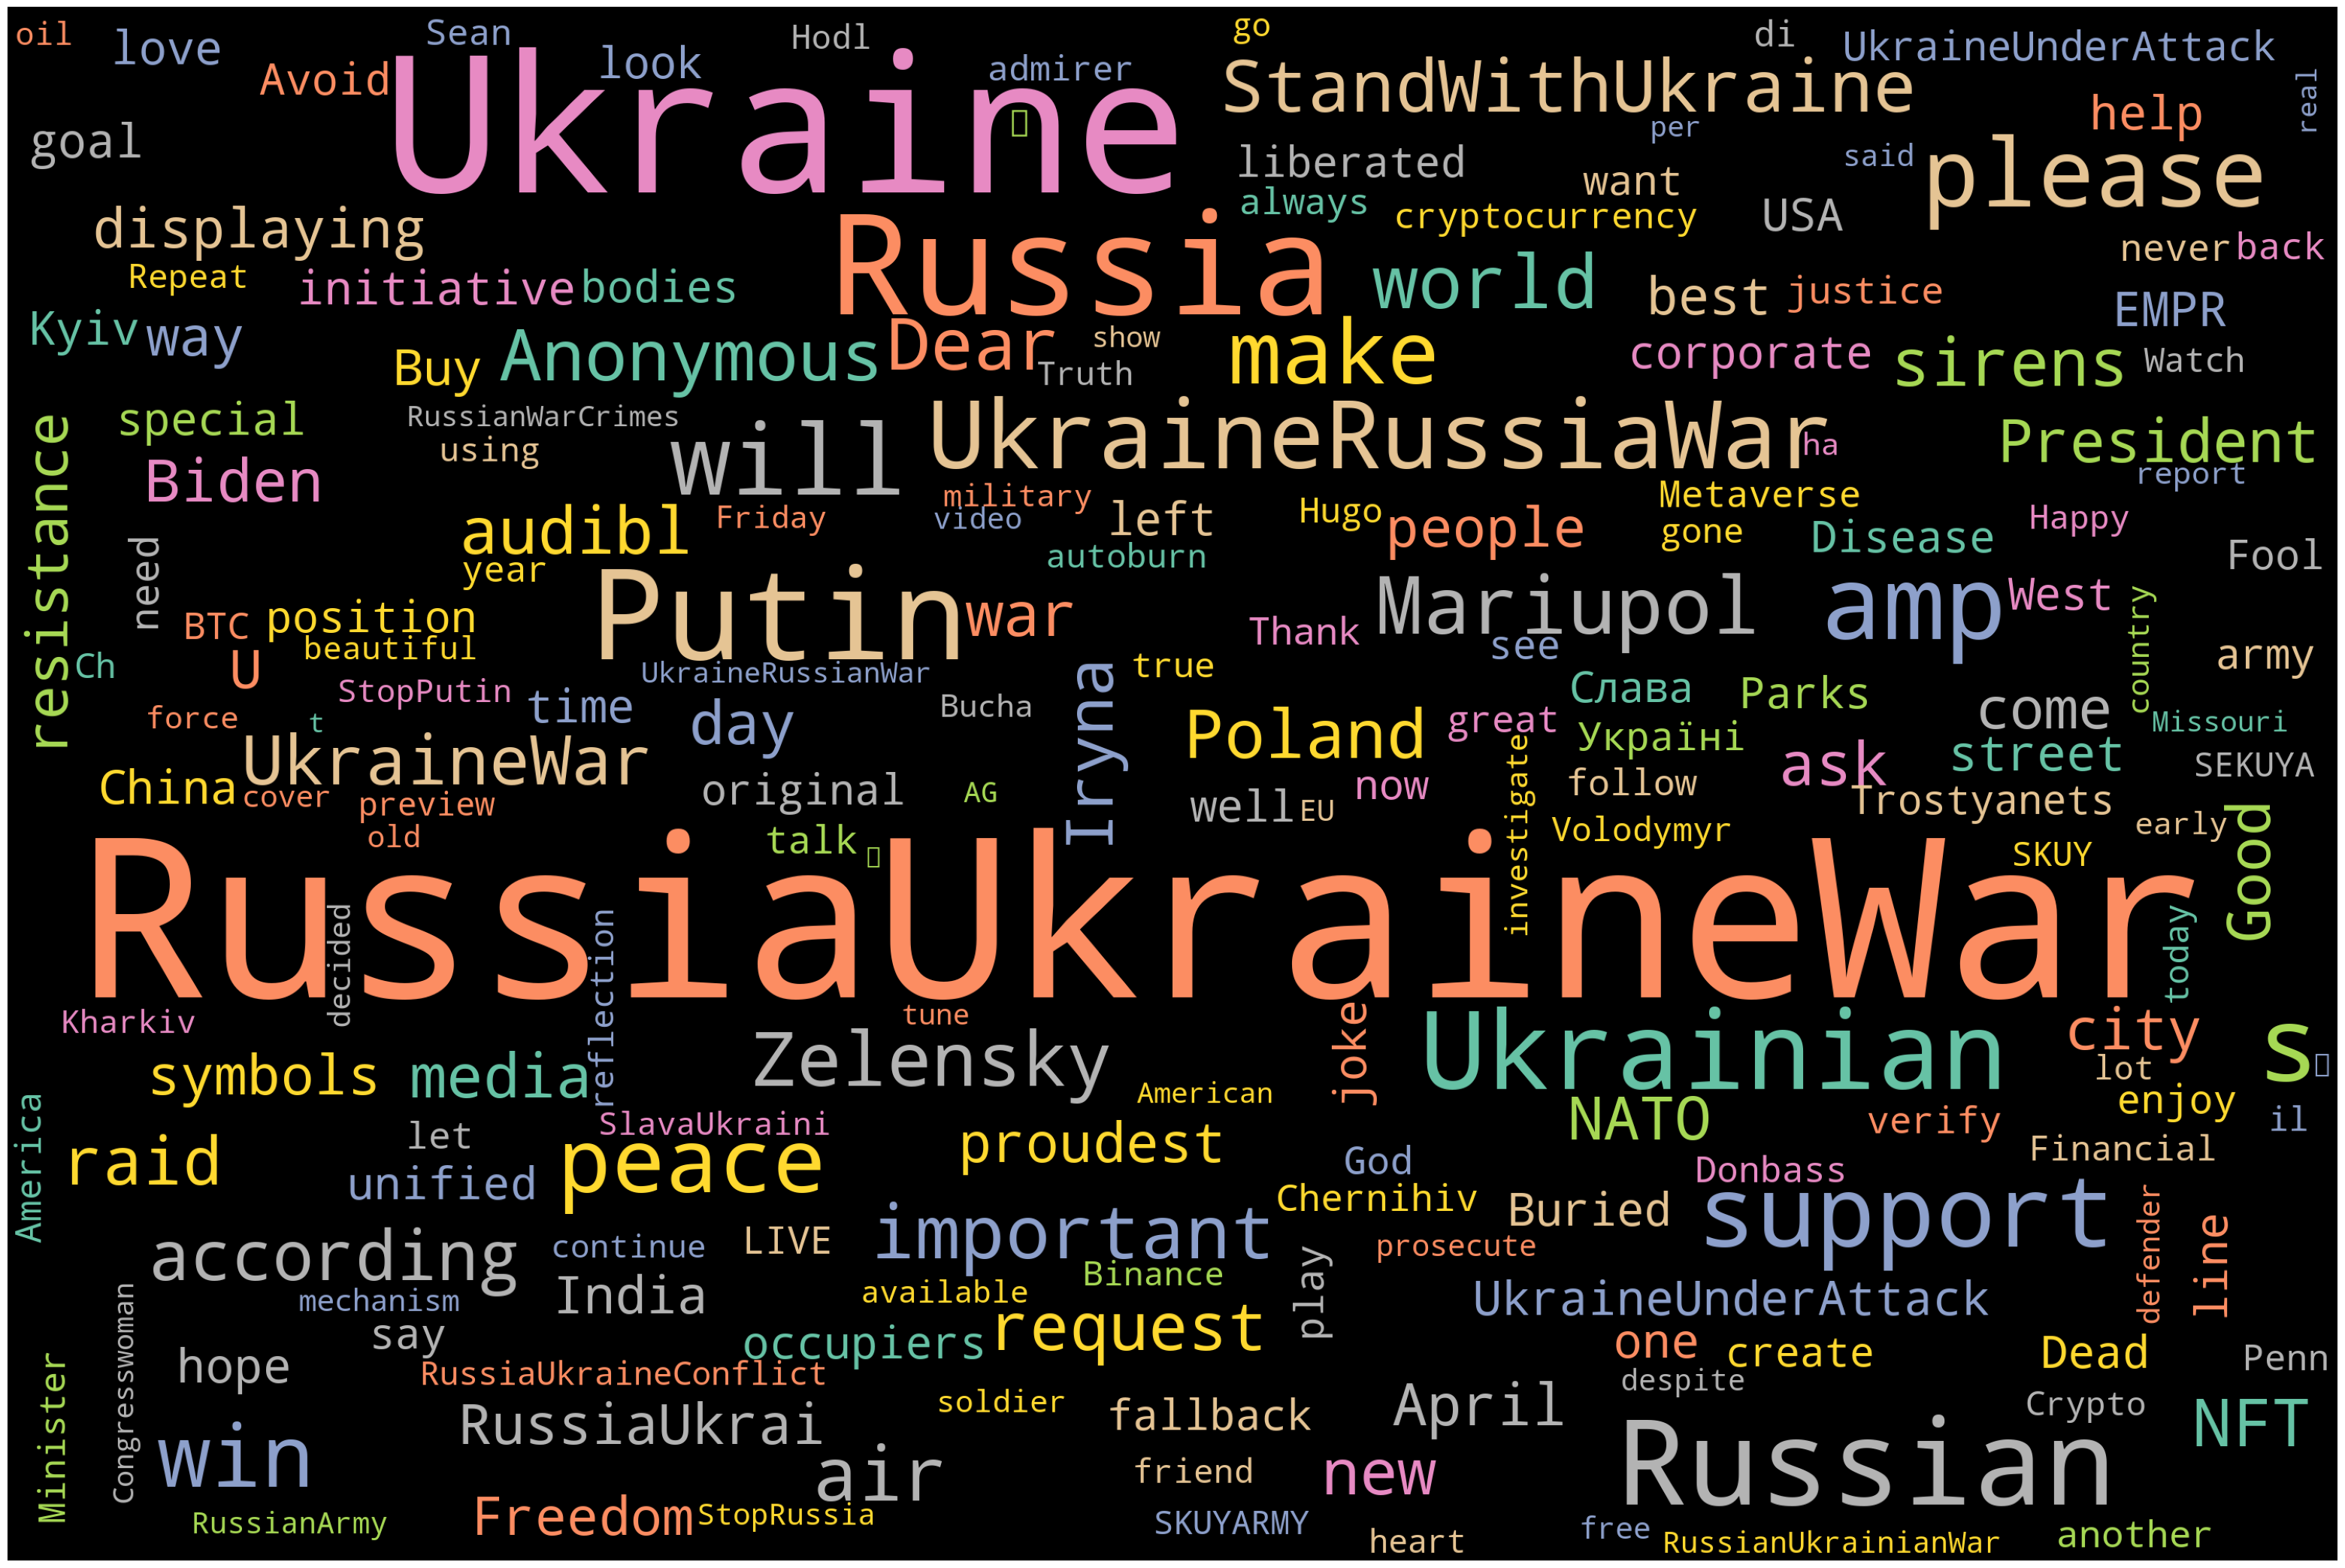

In [14]:
text = " ".join(review for review in df[df['Category']=='Positive'].Tweet)
wordcloud = WordCloud(width = 3000, height = 2000, stopwords=STOPWORDS, background_color="Black",colormap='Set2', collocations=False).generate(text)
plot_cloud(wordcloud)

**Wordcloud for Neutral Sentiments**

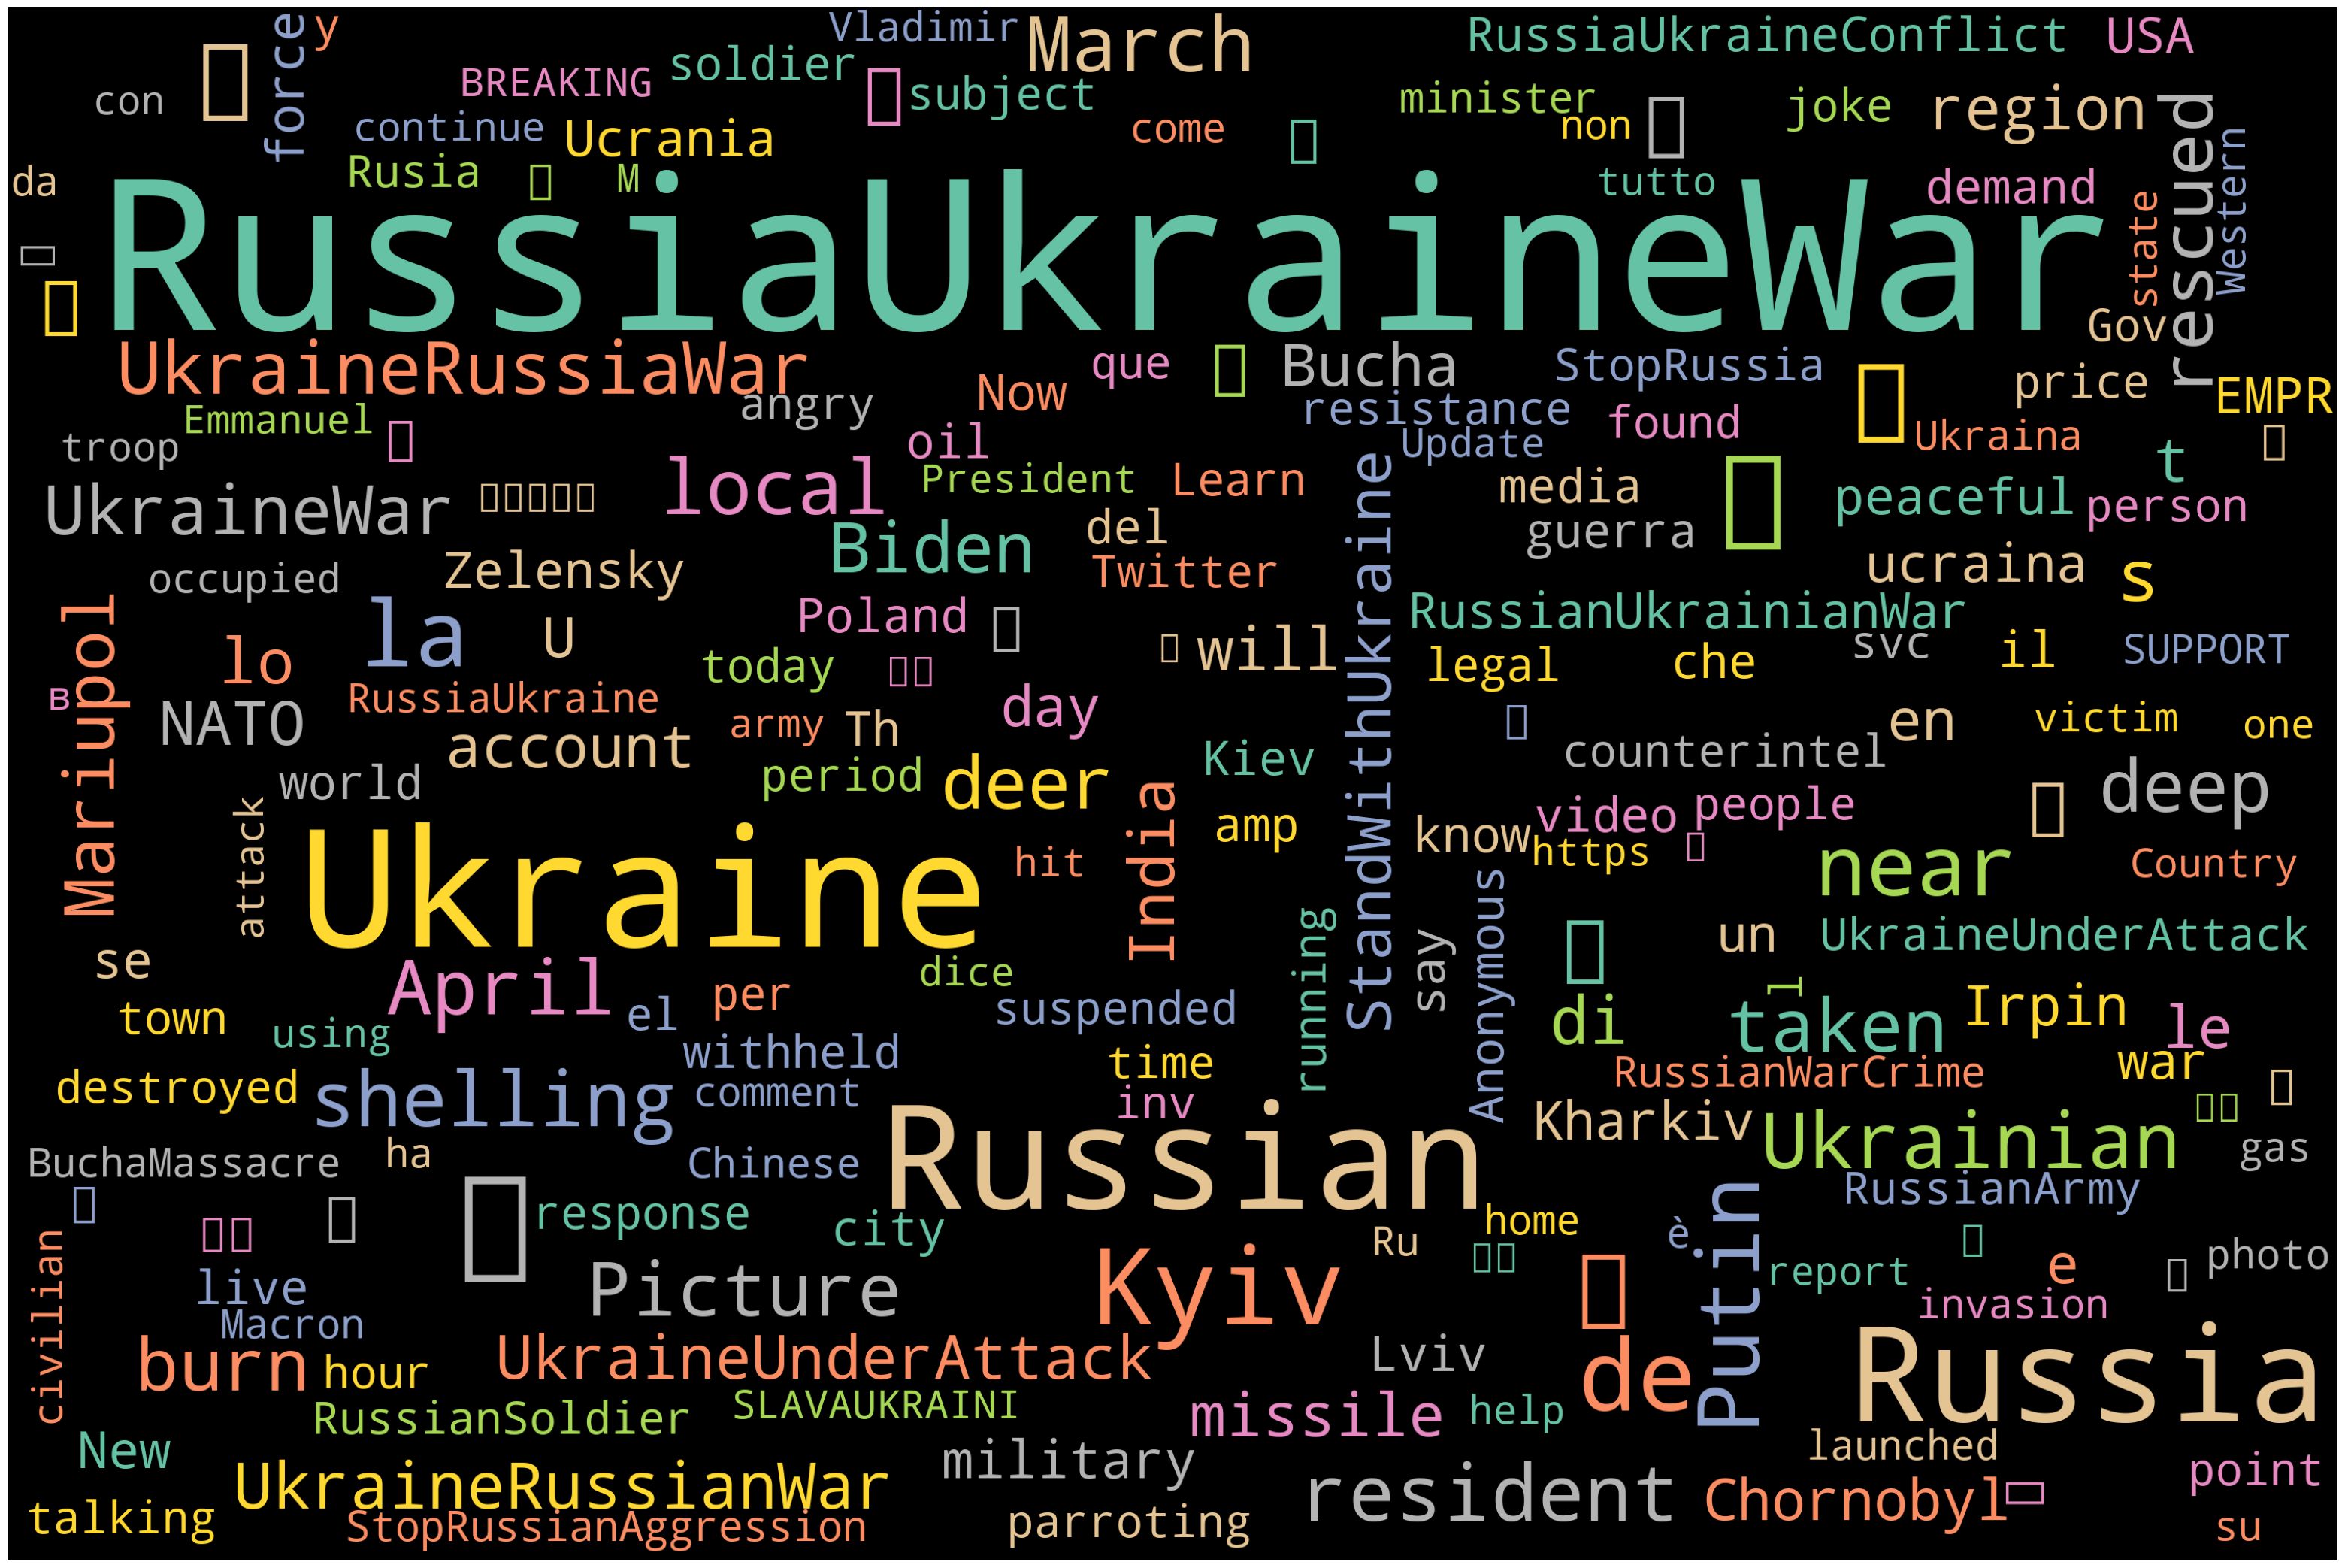

In [15]:
text = " ".join(review for review in df[df['Category']=='Neutral'].Tweet)
wordcloud = WordCloud(width = 3000, height = 2000, stopwords=STOPWORDS, background_color="Black",colormap='Set2', collocations=False).generate(text)
plot_cloud(wordcloud)